# Data-analyysin osaaja

# Koulutus: 21.11.-22.11.2019

# Aihe: Muuttujien valinta lineaarisessa regressiossa

Tässä harjoituksessa tutustumme Lars-algoritmiin, joka valitsee muuttujia osana mallin oppimista datasta. Oppimisen jälkeen saamme lineaarisen mallin, jossa on vain osa alkuperäisistämuuttujista. Ennen kuin muutat mitään, aja kaikki koodi läpi ja katso miten muuttujia valitaan (graafinen esitys).

Ensin tarvitaan kuitenkin tavalliset kirjastot, josta saamme tietorakenteita ja funktiota käyttöön:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lars, lars_path

Harjoitus 1. Muokkkaa alla olevaa notebookia niin, että saat opittua monen muuttujan lineaarisen mallin datasta. Voit ladata vaikka sklearn-kirjastosta datan funktiolla fetch_california_housing (katso dokumentaatiota!).

Käytä ratkaisussa Lars-algoritmia ja tutki mitä muuttujia malliin tulee valituksi.

In [3]:
(california_x, california_y) = datasets.fetch_california_housing(return_X_y=True)

In [4]:
california_x.shape

(20640, 8)

In [5]:
california_y.shape

(20640,)

# Jaa data opetusjoukkoon ja validointijoukkoon:

Opetetaan malli opetusdatasta, jätä toistaiseksi validointidata käyttämättä:

In [6]:
data_x_opetus, data_x_validointi, data_y_opetus, data_y_validointi = train_test_split(
...     california_x, california_y, test_size=0.2, random_state=0)

.

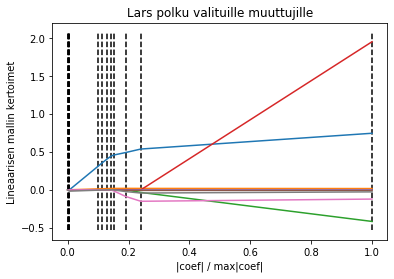

In [8]:
# Tutkitaan miten muuttujia valitaan lineaariseen malliin:

# Käytetään Lars-algortimia, esitetään visuaalisesti tulokset:
_, _, coefs = lars_path(california_x, california_y, method='lars', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Lineaarisen mallin kertoimet')
plt.title('Lars polku valituille muuttujille')
plt.axis('tight')
plt.show()

Tutkitaan yllä olevaa kuvaajaa ja valitaan haluttujen muuttujien määrä lineaarisessa mallissa.

In [9]:
# Lineaarinen malli sovitetaan opetusdataan:
# Luo Lars-malli ensin:

lars = Lars(fit_intercept=True, n_nonzero_coefs=1)

lars.fit(data_x_opetus,data_y_opetus)

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True, fit_path=True,
     n_nonzero_coefs=1, normalize=True, positive=False, precompute='auto',
     verbose=False)

In [10]:
lars.coef_

array([0.31881724, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [11]:
# Lasketaan ennustusten opetusvirhe (MSE = mean squared error eli keskimääräinen neliövirhe)
ennustukset_opetus = lars.predict(data_x_opetus)
opetus_mse = mean_squared_error(data_y_opetus, ennustukset_opetus)
opetus_mse

0.7335263445686798

In [12]:
# Lasketaan ennustusten validointivirhe
ennustukset_validointi = lars.predict(data_x_validointi)
validointi_mse = mean_squared_error(data_y_validointi, ennustukset_validointi)
validointi_mse

0.7488731883878883

Nyt harjoitellaan ristiinvaidointia, jossa data jaetaan opetusjoukkoon ja validointijoukkoon monta kertaa. Kullekin jaolle opetetaan malli opetusdatalla ja mallille lasketaan sekä opetusvirhe että validointivirhe.

In [13]:
# Opetusvirheet tallennetaan taulukkoon:
opetus_mse = np.zeros(10)
opetus_r2 = np.zeros(10)

# Validointivirheet tallenetaan taulukkoon:
validointi_mse = np.zeros(10)
validointi_r2 = np.zeros(10)

# Toista jako opetus- ja validointidataan 10 kertaa, opeta
# joka kerta uusi malli, jolle lasket opetusvirheen (opetusdatan
# avulla) ja validointivirheen(validointidatan avulla)

for i in np.arange(0,10):
  data_x_opetus, data_x_validointi, data_y_opetus, data_y_validointi = train_test_split(california_x, california_y, test_size=0.2, random_state=689*i)

  # Opetetaan malli tällä nimenomaisella jaolla!
  lars.fit(data_x_opetus,data_y_opetus)

  # Lasketaan ennustusten opetusvirhe (MSE ja R2):
  ennustukset_opetus = lars.predict(data_x_opetus)
  opetus_mse[i] = mean_squared_error(data_y_opetus, ennustukset_opetus)
  opetus_r2[i] = r2_score(data_y_opetus, ennustukset_opetus)

  # Lasketaan ennustusten validointivirhe (MSE ja R2):
  ennustukset_validointi = lars.predict(data_x_validointi)
  validointi_mse[i] = mean_squared_error(data_y_validointi, ennustukset_validointi)
  validointi_r2[i] = r2_score(data_y_validointi, ennustukset_validointi)

In [14]:
# 10 toistoa, 10 virhettä (MSE):
print(opetus_mse)

[0.73352634 0.73569827 0.75339593 0.72815702 0.74047254 0.74194264
 0.74117814 0.74160567 0.75400135 0.73437416]


In [15]:
# Yleensä raportoidaan toistettujen mallinnusten keskimääräinen virhe:
print(np.mean(opetus_mse))

0.7404352058372398


In [16]:
# Kymmenen toistoa, 10 virhettä (MSE)
print(validointi_mse)

[0.74887319 0.76028578 0.68641073 0.76018356 0.72486539 0.72329406
 0.7455839  0.71886982 0.67342373 0.7569251 ]


In [17]:
# Yleensä raportoidaan toistettujen mallinnusten keskimääräinen virhe:
print(np.mean(validointi_mse))

0.7298715260447868


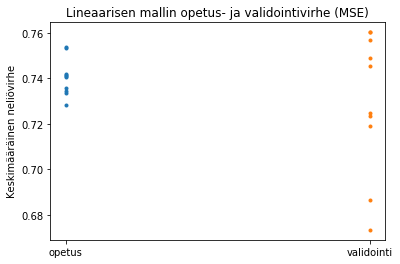

In [18]:
# Tee tuloskuva, jossa opetusvirheet ja validointivirheet
# on visualisoitu:
plt.plot(np.ones((10,1)), opetus_mse, '.')
plt.plot(2*np.ones((10,1)), validointi_mse, '.')
plt.title('Lineaarisen mallin opetus- ja validointivirhe (MSE)')
plt.xticks([1,2], ['opetus', 'validointi'])
plt.ylabel('Keskimääräinen neliövirhe')
plt.show()

In [19]:
# 10 toistoa, 10 selitysastetta:
print(opetus_r2)

[0.45192621 0.44172391 0.43924918 0.45279778 0.44605081 0.44383727
 0.4407472  0.44564845 0.44047932 0.44518003]


In [20]:
# Yleensä raportoidaan toistettujen mallinnusten keskimääräinen selitysaste:
print(np.mean(opetus_r2))

0.444764014961417


In [21]:
# 10 toistoa, 10 selitysastetta:
print(validointi_r2)

[0.42569088 0.45155903 0.46497056 0.43053936 0.4470009  0.4526442
 0.45019029 0.4498042  0.46835442 0.44453544]


In [22]:
# Yleensä raportoidaan toistettujen mallinnusten keskimääräinen selitysaste:
print(np.mean(validointi_r2))

0.4485289292371399


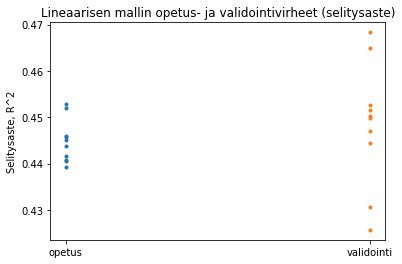

In [23]:
# Tee tuloskuva, jossa opetusvirheet ja validointivirheet
# on visualisoitu:
plt.plot(np.ones((10,1)), opetus_r2, '.')
plt.plot(2*np.ones((10,1)), validointi_r2, '.')
plt.title('Lineaarisen mallin opetus- ja validointivirheet (selitysaste)')
plt.xticks([1,2], ['opetus', 'validointi'])
plt.ylabel('Selitysaste, R^2')
plt.show()

Tehtävä 1. Kokeile samaa analyysiketjua jollakin muulla datalla, jossa on yksi syötemuuttuja ja yksi vastemuuttuja. Voit valita datan vaikka kirjastosta sklearn.datasets ja poimia datasta haluamasi syötemuuttujan x ja vastemuuttujan y. Mieti tarvitaanko malliin molemmat paramterit a ja b, tai vain a?